In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

See [here for inflation factor](https://www.census.gov/programs-surveys/acs/guidance/comparing-acs-data/2016.html) to compare ACS 2016 to Census 2000 income

In [2]:
db = "/home/eric/Documents/franklin/cost_burden/generated_data/cost_burden.sqlite"
con = sql.connect(db)

qry = '''
SELECT A.GISJOIN, 
A.AF2LE001 AS pop16,
B.AGQ1E003 AS med_renter_inc_16,
A.AF89E001 AS med_gross_rent_16,
(A.AF9FE007 + A.AF9FE008 + A.AF9FE009 +  A.AF9FE010) * 1.0 / AF9FE001 * 100 
    AS renter_cost_burden_16,
C.FL5001 AS pop00,
D.GED002 * 1.4415372 AS med_renter_inc_00,
D.GBO001 * 1.4415372 AS med_gross_rent_00,
(D.GBW006 + D.GBW007 + D.GBW008 + D.GBW009) * 1.0 / 
    (D.GBW001 + D.GBW002 + D.GBW003 + D.GBW004 + D.GBW005 + D.GBW006 + D.GBW007 + D.GBW008 + D.GBW009 + D.GBW010) * 100
    AS renter_cost_burden_00
FROM nhgis_20165_county_ds225 AS A JOIN nhgis_20165_county_ds226 AS B
    ON A.GISJOIN = B.GISJOIN 
JOIN nhgis_2000_county_ds146 AS C 
    ON A.GISJOIN = C.GISJOIN
JOIN nhgis_2000_county_ds151 AS D
    ON A.GISJOIN = D.GISJOIN
WHERE A.STATEA NOT IN ('72', '02', '15')
AND B.AGQ1M003 <> '' AND A.AF89E001 <> ''
AND C.FL5001 > 1000
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')

print len(df)
print df.head()

con.close()

3072
           pop16  med_renter_inc_16  med_gross_rent_16  renter_cost_burden_16  \
GISJOIN                                                                         
G0100010   55049              35549                896              49.731279   
G0100030  199510              33665                889              43.014498   
G0100050   26614              17339                588              42.119648   
G0100070   22572              28135                654              34.784863   
G0100090   57704              26215                631              31.935853   

           pop00  med_renter_inc_00  med_gross_rent_00  renter_cost_burden_00  
GISJOIN                                                                        
G0100010   43671       38915.738251         774.105476              27.687188  
G0100030  140415       38171.905056         815.910055              33.474921  
G0100050   29038       17781.361362         480.031888              32.904884  
G0100070   20826       2534

In [3]:
df.dtypes

pop16                      int64
med_renter_inc_16          int64
med_gross_rent_16          int64
renter_cost_burden_16    float64
pop00                      int64
med_renter_inc_00        float64
med_gross_rent_00        float64
renter_cost_burden_00    float64
dtype: object

In [4]:
df.loc['G2601630']['med_renter_inc_16']

23705.0

In [5]:
# calc pop change in each decade
df['ppctchg_0016'] = ( df['pop16'] - df['pop00'] ) * 1.0 / df['pop00'] * 100

# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0016'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0016'] < 5) & (df['ppctchg_0016'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0016'] < 0, 'growth_cat'] = 'shrinking'

df.groupby('growth_cat').size()

growth_cat
growing      1330
shrinking    1195
stable        547
dtype: int64

In [6]:
# create index values where 100 = 2000 val
cols = ['med_renter_inc', 'med_gross_rent']
for c in cols:
    df['{}_00_idx'.format(c)] = df['{}_00'.format(c)] / df['{}_00'.format(c)] * 100

for c in cols:
    df['{}_16_idx'.format(c)] = df['{}_16'.format(c)] / df['{}_00'.format(c)] * 100


df.head()

,pop16,med_renter_inc_16,med_gross_rent_16,renter_cost_burden_16,pop00,med_renter_inc_00,med_gross_rent_00,renter_cost_burden_00,ppctchg_0016,growth_cat,med_renter_inc_00_idx,med_gross_rent_00_idx,med_renter_inc_16_idx,med_gross_rent_16_idx
GISJOIN,,,,,,,,,,,,,,
G0100010,55049,35549,896,49.731279,43671,38915.738251,774.105476,27.687188,26.053903,growing,100.0,100.0,91.348646,115.746501
G0100030,199510,33665,889,43.014498,140415,38171.905056,815.910055,33.474921,42.085959,growing,100.0,100.0,88.193136,108.958088
G0100050,26614,17339,588,42.119648,29038,17781.361362,480.031888,32.904884,-8.347682,shrinking,100.0,100.0,97.512219,122.491863
G0100070,22572,28135,654,34.784863,20826,25346.548588,501.654946,25.232975,8.383751,growing,100.0,100.0,111.001306,130.368494
G0100090,57704,26215,631,31.935853,51024,28450.178179,554.991822,21.396629,13.091878,growing,100.0,100.0,92.143535,113.695369


(0, 35215.493899079993)

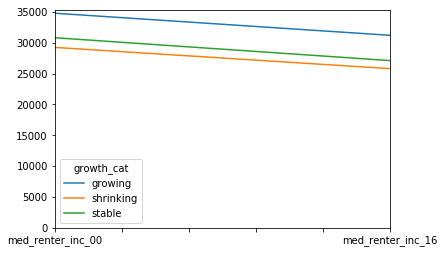

In [7]:
grouped = df.groupby('growth_cat')
cols = ['med_renter_inc_00', 'med_renter_inc_16']
ax=grouped[cols].median().transpose().plot()
ax.set_ylim(0)

(80, 115)

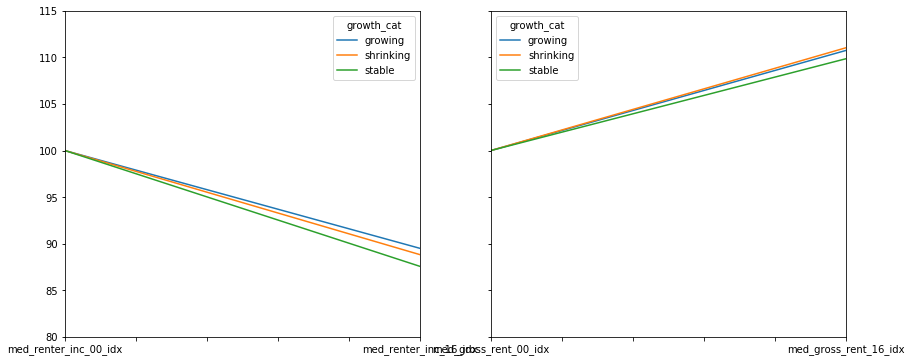

In [8]:
w = 14
h = 6
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

cols = ['med_renter_inc_00_idx', 'med_renter_inc_16_idx']
grouped[cols].median().transpose().plot(ax=ax1)

cols = ['med_gross_rent_00_idx', 'med_gross_rent_16_idx']
ax=grouped[cols].median().transpose().plot(ax=ax2)


ax1.set_ylim(80, 115)

In [9]:
# calc diff for each county
df['renter_inc_diff'] = df['med_renter_inc_16_idx'] - 100
df['gross_rent_diff'] = df['med_gross_rent_16_idx'] - 100

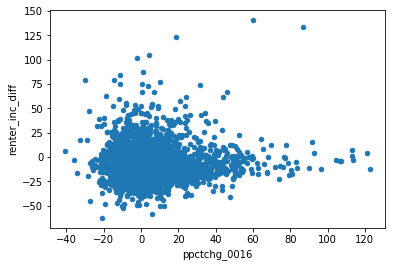

In [10]:
df.plot.scatter('ppctchg_0016', 'renter_inc_diff')

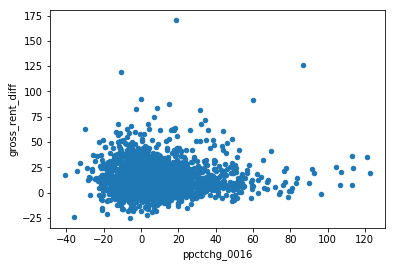

In [11]:
df.plot.scatter('ppctchg_0016', 'gross_rent_diff')

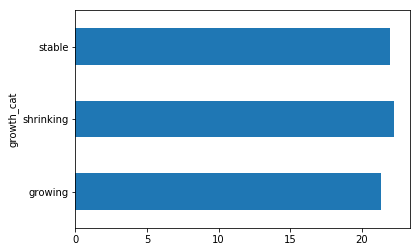

In [12]:
# plot gap between rent increase and income decrease
df['idx_gap'] = df['med_gross_rent_16_idx'] - df['med_renter_inc_16_idx']
df.groupby('growth_cat')['idx_gap'].median().transpose().plot(kind='barh')

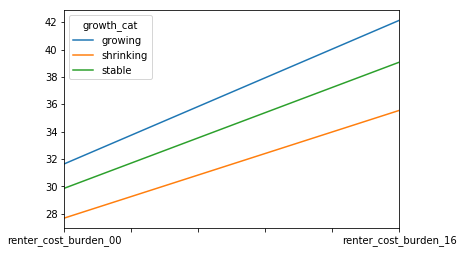

In [13]:
cols = ['renter_cost_burden_00', 'renter_cost_burden_16']
grouped[cols].median().transpose().plot()

In [18]:
df.loc['G2601630']

pop16                      1767593
med_renter_inc_16            23705
med_gross_rent_16              808
renter_cost_burden_16      51.8774
pop00                      2061162
med_renter_inc_00          34795.8
med_gross_rent_00          764.015
renter_cost_burden_00      37.0943
ppctchg_0016              -14.2429
growth_cat               shrinking
med_renter_inc_00_idx          100
med_gross_rent_00_idx          100
med_renter_inc_16_idx       68.126
med_gross_rent_16_idx      105.757
renter_inc_diff            -31.874
gross_rent_diff            5.75713
idx_gap                    37.6311
Name: G2601630, dtype: object